House Pricing predictive model

Objetivo:

Cada columna en el conjunto de datos describe una característica de la casa
Nuestra meta es predecir la variable "SalePrice" o precio de venta dadas las características de la casa

Método de evaluación de efectividad:
El modelo propuesto será evaluado a través de: Root-Mean-Squared-Error (RMSE)

Puntos Clave:
Modelo: CatBoost que es un algoritmo de basado en el método de boosting de gradientes y está diseñado para trabajar eficientemente con conjuntos de datos que contienen características categóricas. 
Se seleccionó ese modelo por la facilidad en el Manejo de Características Categóricas: puede manejar características categóricas automáticamente sin necesidad de realizar una codificación previa manual, como One-Hot Encoding. Utiliza un método especial llamado codificación de contraste de objetivo para lidiar con estas características, lo que reduce el riesgo de sobreajuste y además puede manejar automáticamente los datos faltantes sin necesidad de imputación previa.

In [1]:
# Librerías a utilizar
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from math import sqrt

from catboost import CatBoostRegressor, Pool

EDA

Primero hacemos una revisión de las bases de datos con las que trabajaremos

In [2]:
# Cargar los datasets
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Mostrar las primeras filas de cada dataset para tener una idea del contenido
train_data.head(), test_data.head()

(   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
 0   1          60       RL         65.0     8450   Pave   NaN      Reg   
 1   2          20       RL         80.0     9600   Pave   NaN      Reg   
 2   3          60       RL         68.0    11250   Pave   NaN      IR1   
 3   4          70       RL         60.0     9550   Pave   NaN      IR1   
 4   5          60       RL         84.0    14260   Pave   NaN      IR1   
 
   LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
 0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
 1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
 2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
 3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
 4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   
 
   YrSold  SaleType  SaleCondition  SalePrice  
 0   2

Variable Objetivo: 'SalePrice'

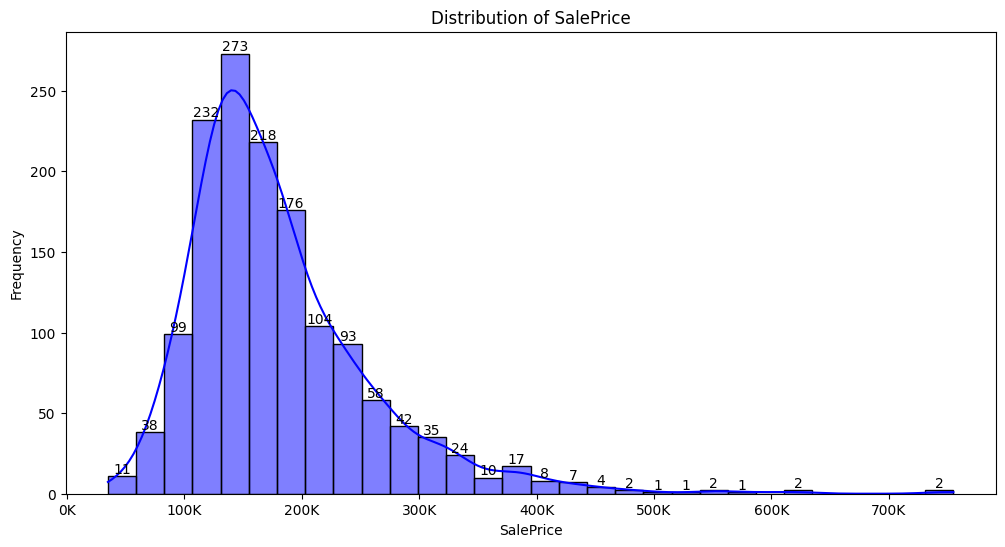

In [3]:
# Visualización de la distribución de SalePrice
# Función para formatear el eje x con comas
def thousand_formatter(x, pos):
    return f'{int(x/1000)}K'

# Crear el histograma
plt.figure(figsize=(12, 6))
ax = sns.histplot(train_data['SalePrice'], kde=True, color="blue", bins=30)

# Establecer el título y las etiquetas
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')

# Formatear el eje x con comas
ax.xaxis.set_major_formatter(FuncFormatter(thousand_formatter))

# Añadir el número de casos encima de cada barra
for p in ax.patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    if y > 0:
        ax.annotate(f'{int(y)}', (x, y), ha='center', va='bottom')

plt.show()


Podemos ver que la varaible objetivo está sesgada hacia la derecha. Y además encontramos pocas casas (aprox 14) arriba del precio de 450,000

Correlación de variables numéricas con la variable objetivo

C:\Users\lp_s9\AppData\Local\Temp\ipykernel_20404\712381453.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_data.corr(), cmap="coolwarm")


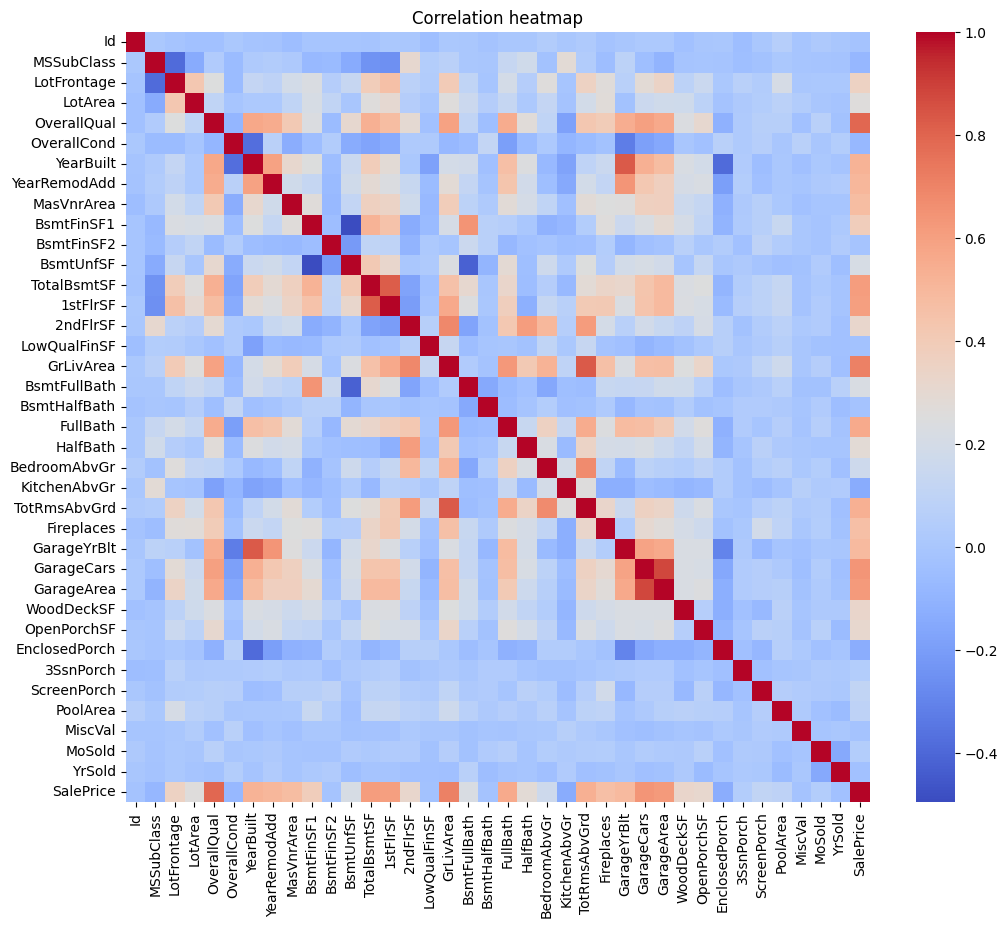

In [4]:
# Visualización de la correlación entre características numéricas y SalePrice
plt.figure(figsize=(12, 10))
sns.heatmap(train_data.corr(), cmap="coolwarm")
plt.title('Correlation heatmap')
plt.show()

Variables más correlacionadas con 'SalePrice'

In [5]:
# Calcular la matriz de correlación
correlation_matrix = train_data.corr()

# Obtener las correlaciones con la variable 'SalePrice'
saleprice_correlation = correlation_matrix['SalePrice'].sort_values(ascending=False)

# Mostrar las 5 variables que más se correlacionan (excluyendo 'SalePrice' a sí misma)
top_correlations = saleprice_correlation[1:6]
print(top_correlations)


OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
TotalBsmtSF    0.613581
Name: SalePrice, dtype: float64


C:\Users\lp_s9\AppData\Local\Temp\ipykernel_20404\2602174649.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train_data.corr()


Ingeniería de Variables

In [6]:
# Dividir variables y etiquetas
train_labels = train_data['SalePrice'].reset_index(drop=True)
train_features = train_data.drop(['SalePrice'], axis=1)
test_features = test_data

# Combinar conjuntos de datos de entrenamiento y prueba para aplicar el proceso de transformación a todo el conjunto de datos.
all_features = pd.concat([train_features, test_features]).reset_index(drop=True)
all_features.shape

(2919, 80)

Valores Faltantes:

Al revisar las bases de datos es evidente que muchas columnas/características cuentan con valoes faltantes.

Por lo cual haremos una revisión de estas para ver la profundidad de esta situación 

(PoolQC          1453
 MiscFeature     1406
 Alley           1369
 Fence           1179
 FireplaceQu      690
 LotFrontage      259
 GarageType        81
 GarageYrBlt       81
 GarageFinish      81
 GarageQual        81
 GarageCond        81
 BsmtExposure      38
 BsmtFinType2      38
 BsmtFinType1      37
 BsmtCond          37
 BsmtQual          37
 MasVnrArea         8
 MasVnrType         8
 Electrical         1
 dtype: int64,
 count      1460.000000
 mean     180921.195890
 std       79442.502883
 min       34900.000000
 25%      129975.000000
 50%      163000.000000
 75%      214000.000000
 max      755000.000000
 Name: SalePrice, dtype: float64)

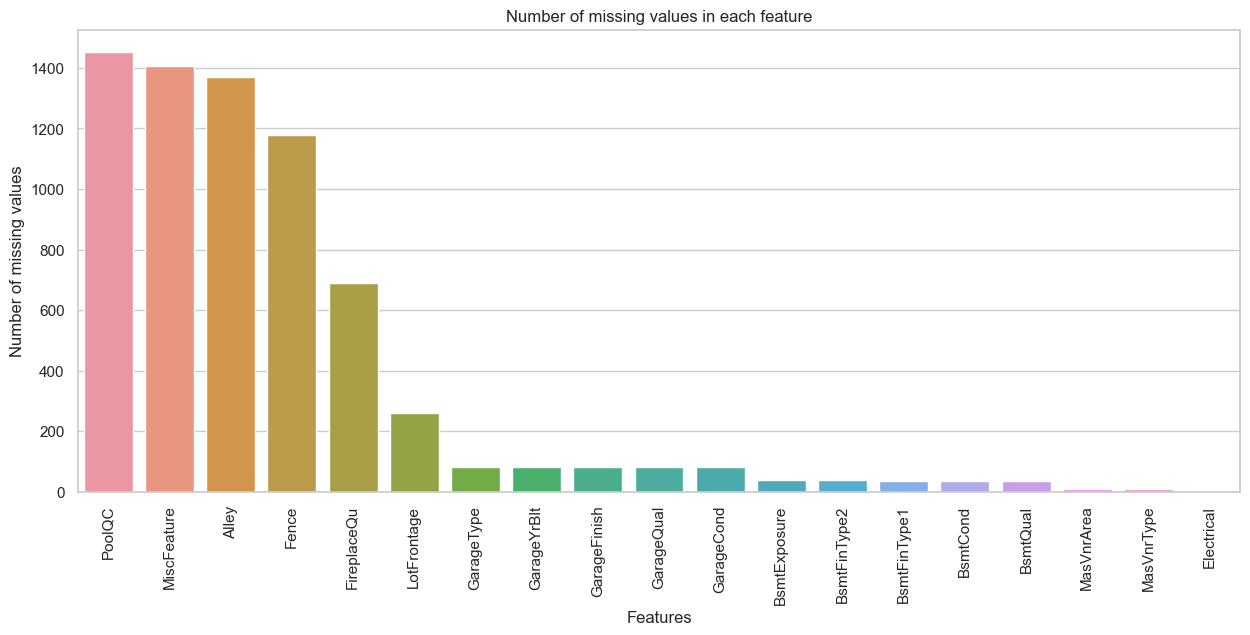

In [7]:
# Análisis de valores faltantes
missing_values = train_data.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

sns.set(style="whitegrid")
# Visualización de valores faltantes
plt.figure(figsize=(15, 6))
sns.barplot(x=missing_values.index, y=missing_values)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Number of missing values')
plt.title('Number of missing values in each feature')

missing_values, train_data['SalePrice'].describe()

Podemos ver que las variables 'PoolQC', 'MiscFeature', 'Alley', 'Fence' y 'FireplaceQu' son las que más presentan valores faltantes (NA) por lo cual comenzaremos por decidir como aboradr este problema para todas las variables que presenten este problema

In [8]:
def handle_missing(features):
    #  En la descripción de los datos se hace la aclaración de que NA se refiere a tipico ('Typ')
    features['Functional'] = features['Functional'].fillna('Typ')
    # Reemplazar los valores NA con la moda
    features['Electrical'] = features['Electrical'].fillna("SBrkr")
    features['KitchenQual'] = features['KitchenQual'].fillna("TA")
    features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
    features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
    features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])
    features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    
    # En la descripción de los datos se hace la aclaración de que NA se refiere a "No Pool"
    features["PoolQC"] = features["PoolQC"].fillna("None")
    # Reemplazando NA con 0 ya que si no tiene garage, no tiene coches
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        features[col] = features[col].fillna(0)
    # reemplazando los NA con 'None'
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        features[col] = features[col].fillna('None')
    # Los valores NA indican que no existe el sótano 
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        features[col] = features[col].fillna('None')
        
    # Agrupar por colonia y llenar con la mediana
    features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    # Para las demás variables reemplazamos con 'none'
    objects = []
    for i in features.columns:
        if features[i].dtype == object:
            objects.append(i)
    features.update(features[objects].fillna('None'))
        
    # Hacemos lo mismo con las variables numéricas pero reemplazamos con 0
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = []
    for i in features.columns:
        if features[i].dtype in numeric_dtypes:
            numeric.append(i)
    features.update(features[numeric].fillna(0))    
    return features

all_features = handle_missing(all_features)

In [9]:
# Separación del conjunto de datos, número de filas en el conjunto de entrenamiento original
num_train = train_data.shape[0]

# Separar el conjunto de características combinado de nuevo en conjuntos de entrenamiento y prueba
train_features = all_features[:num_train]
test_features = all_features[num_train:]

# Verificar las dimensiones para asegurarse de que todo está correcto
print(train_features.shape, test_features.shape)


(1460, 80) (1459, 80)


Modelo CatBoost

Entrenamiento

In [11]:
# Identificar las características categóricas
cat_features = [col for col in train_features.columns if train_features[col].dtype == 'object']

# Definir el modelo CatBoost
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='RMSE',
    verbose=200
)

# Entrenar el modelo usando todo el conjunto de datos de entrenamiento
model.fit(train_features, train_labels, cat_features=cat_features)

0:	learn: 74297.3717235	total: 195ms	remaining: 3m 14s
200:	learn: 13406.4963990	total: 13.6s	remaining: 54.1s
400:	learn: 9126.7615961	total: 27s	remaining: 40.4s
600:	learn: 6858.0079653	total: 40.5s	remaining: 26.9s
800:	learn: 5354.4666045	total: 53.8s	remaining: 13.4s
999:	learn: 4379.2038459	total: 1m 7s	remaining: 0us


Predicciones

In [12]:
# Hacer predicciones en el conjunto de prueba
predictions = model.predict(test_features)

# Preparar el archivo de envío
submission = pd.DataFrame({
    'Id': test_data['Id'], 
    'SalePrice': predictions
})

# Guardar el archivo de envío en formato CSV
submission_filepath = 'submission_catboost-total.csv'
submission.to_csv(submission_filepath, index=False)
print(f'Submission file has been saved to: {submission_filepath}')


Submission file has been saved to: submission_catboost-total.csv
